episode: 0
episode: 1000


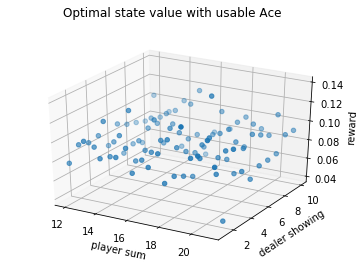

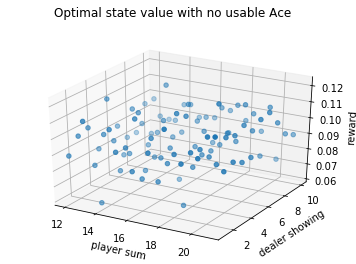

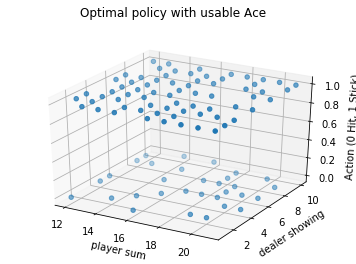

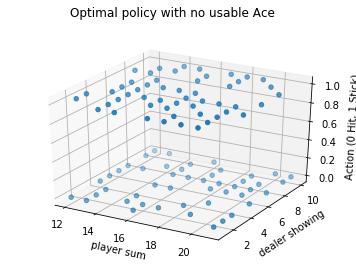

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

STICK = 1
HIT = 0

playerPolicy = np.zeros(22)
dealerPolicy = np.zeros(22)
value = np.zeros((2,10,10)) # indexed to (usable ace,dealer showing, player sum)
returns = np.empty((2,10,10),dtype=np.object_) # same indexing
playerMoves = []

for i in range(17,22):
    dealerPolicy[i] = 1
for i in range(20,22):
    playerPolicy[i] = 1
for index,val in np.ndenumerate(returns):
    returns[index]=[]

def dealerPolicyFn(state):
    if dealerPolicy[state[1]] == 1:
        return STICK
    else:
        return HIT
def targetPlayerPolicyFn(state):
    if playerPolicy[state[1]] == 1:
        return STICK
    else:
        return HIT
def getCard():
    card = np.random.randint(1,14)
    card = min(10,card)
    return card
def game(playerPolicyFn,initialState=None,initialAction=None):
    if initialState == None: 
        playerSum = 0
        playerUsableAce = 0
        pAces = 0
        while playerSum < 12:
            card = getCard()
            if card == 1:
                pAces += 1
                card = 11
                playerUsableAce = 1
            playerSum += card
        if playerSum > 21:
            playerSum -= 10
            if pAces == 1:
                playerUsableAce = 0
        dealerCard1 = getCard() # shown
        dealerCard2 = getCard()
    else:
        playerUsableAce = initialState[0]
        playerSum = initialState[1]
        dealerCard1 = initialState[2]
        dealerCard2 = getCard()
    state = [playerUsableAce,playerSum,dealerCard1] # state
    dealerSum = 0
    dealerUsableAce = 0
    if dealerCard1 == 1 and dealerCard2 != 1:
        dealerSum += 11 + dealerCard2
    elif dealerCard1 != 1 and dealerCard2 == 1:
        dealerSum += 11 + dealerCard1
    elif dealerCard1 == 1 and dealerCard2 == 1:
        dealerSum = 12
    else:
        dealerSum += dealerCard1 + dealerCard2
    while True:
        if initialAction is not None:
            action = initialAction
            initialAction = None
        else:
            action = playerPolicyFn(state)

        playerMoves.append([action,state])

        if playerPolicyFn(state) == STICK:
            break
        playerSum += getCard()
        if playerSum > 21:
            if playerUsableAce == 1:
                playerSum -= 10
                playerUsableAce = 0
            else:
                return state,-1,playerMoves
    while True:
        action = dealerPolicyFn(state)
        if action == STICK:
            break
        dealerSum += getCard()
        if dealerSum > 21:
            if dealerUsableAce == True:
                dealerSum -= 10
                dealerUsableAce = False
            else:
                return state, 1, playerMoves
    if playerSum > dealerSum:
        return state, 1, playerMoves
    elif playerSum == dealerSum:
        return state, 0, playerMoves
    else:
        return state, -1, playerMoves

def monteCarloOnPolicy(nEpisodes):
    statesUsableAce = np.zeros((10, 10))
    statesUsableAceCount = np.ones((10, 10))
    statesNoUsableAce = np.zeros((10, 10))
    statesNoUsableAceCount = np.ones((10, 10))
    for i in range(0, nEpisodes):
        state, reward, _ = game(targetPlayerPolicyFn)
        state[1] -= 12
        state[2] -= 1
        if state[0]:
            statesUsableAceCount[state[1], state[2]] += 1
            statesUsableAce[state[1], state[2]] += reward
        else:
            statesNoUsableAceCount[state[1], state[2]] += 1
            statesNoUsableAce[state[1], state[2]] += reward
    return statesUsableAce / statesUsableAceCount, statesNoUsableAce / statesNoUsableAceCount
figureIndex=0
def prettyPrint(data, tile, zlabel='reward'):
    global figureIndex
    fig = plt.figure(figureIndex)
    figureIndex += 1
    fig.suptitle(tile)
    ax = fig.add_subplot(111, projection='3d')
    axisX = []
    axisY = []
    axisZ = []
    for i in range(12, 22):
        for j in range(1, 11):
            axisX.append(i)
            axisY.append(j)
            axisZ.append(data[i - 12, j - 1])
    ax.scatter(axisX, axisY, axisZ)
    ax.set_xlabel('player sum')
    ax.set_ylabel('dealer showing')
    ax.set_zlabel(zlabel)

#prettyPrint(monteCarloOnPolicy(10000)[0], 'suck ur mother')
#plt.show()
actions = [HIT,STICK]
def monteCarloES(nEpisodes):
    # (playerSum, dealerCard, usableAce, action)
    stateActionValues = np.zeros((10, 10, 2, 2))
    # initialze counts to 1 to avoid division by 0
    stateActionPairCount = np.ones((10, 10, 2, 2))

    # behavior policy is greedy
    def behaviorPolicy(state):
        usableAce = int(state[0])
        playerSum = (state[1]) - 12
        dealerCard = (state[2]) - 1
        # get argmax of the average returns(s, a)
        return np.argmax(stateActionValues[playerSum, dealerCard, usableAce, :]
                      / stateActionPairCount[playerSum, dealerCard, usableAce, :])

    # play for several episodes
    for episode in range(nEpisodes):
        if episode % 1000 == 0:
            print('episode:', episode)
        # for each episode, use a randomly initialized state and action
        initialState = [bool(np.random.choice([0, 1])),
                       np.random.choice(range(12, 22)),
                       np.random.choice(range(1, 11))]
        initialAction = np.random.choice(actions)
        _, reward, trajectory = game(behaviorPolicy, initialState, initialAction)
        for action, (usableAce, playerSum, dealerCard) in trajectory:
            usableAce = int(usableAce)
            playerSum -= 12
            dealerCard -= 1
            # update values of state-action pairs
            stateActionValues[playerSum, dealerCard, usableAce, action] += reward
            stateActionPairCount[playerSum, dealerCard, usableAce, action] += 1

    return stateActionValues / stateActionPairCount

def figure5_3():
    stateActionValues = monteCarloES(500000)
    stateValueUsableAce = np.zeros((10, 10))
    stateValueNoUsableAce = np.zeros((10, 10))
    # get the optimal policy
    actionUsableAce = np.zeros((10, 10), dtype='int')
    actionNoUsableAce = np.zeros((10, 10), dtype='int')
    for i in range(10):
        for j in range(10):
            stateValueNoUsableAce[i, j] = np.max(stateActionValues[i, j, 0, :])
            stateValueUsableAce[i, j] = np.max(stateActionValues[i, j, 1, :])
            actionNoUsableAce[i, j] = np.argmax(stateActionValues[i, j, 0, :])
            actionUsableAce[i, j] = np.argmax(stateActionValues[i, j, 1, :])
    prettyPrint(stateValueUsableAce, 'Optimal state value with usable Ace')
    prettyPrint(stateValueNoUsableAce, 'Optimal state value with no usable Ace')
    prettyPrint(actionUsableAce, 'Optimal policy with usable Ace', 'Action (0 Hit, 1 Stick)')
    prettyPrint(actionNoUsableAce, 'Optimal policy with no usable Ace', 'Action (0 Hit, 1 Stick)')
    plt.show()

def offPolicy():
    trueValue = -0.27726
    nEpisodes = 10000
    nRuns = 100
    ordinarySampling = np.zeros(nEpisodes)
    weightedSampling = np.zeros(nEpisodes)
    for i in range(0, nRuns):
        ordinarySampling_, weightedSampling_ = monteCarloOffPolicy(nEpisodes)
        # get the squared error
        ordinarySampling += np.power(ordinarySampling_ - trueValue, 2)
        weightedSampling += np.power(weightedSampling_ - trueValue, 2)
    ordinarySampling /= nRuns
    weightedSampling /= nRuns
    axisX = np.log10(np.arange(1, nEpisodes + 1))
    plt.plot(axisX, ordinarySampling, label='Ordinary Importance Sampling')
    plt.plot(axisX, weightedSampling, label='Weighted Importance Sampling')
    plt.xlabel('Episodes (10^x)')
    plt.ylabel('Mean square error')
    plt.legend()
    plt.show()

figure5_3()